In [803]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import rc
from numpy.core.multiarray import pi
from numpy.core.multiarray import e
import seaborn as sns
np.random.seed(1994)
%matplotlib inline
theta_star = 2.940234732799485



In [804]:
def SQuantization(s,x): 
    
    # s : number of quantization levels
    # x : vector to compress
    
    if s == 0:
        return x
    norm_x = abs(x)#np.linalg.norm(x,2)
    if norm_x == 0:
        return x
    ratio = np.abs(x) / norm_x
    l = np.floor(ratio * s)
    p = ratio * s - l
    sampled = np.random.binomial(1,p)
    qtzt = np.sign(x) * norm_x * (l + sampled) / s
    return qtzt

def com_bits(s,d):
    if s <= np.sqrt(d/2 - np.sqrt(d)):
        return (3 + (3/2) * np.log(2*(s**2 + d)/(s*(s+np.sqrt(d))))) * s*(s+np.sqrt(d)) + 32
    elif s == np.sqrt(d):
        return 2.8*d + 32
    else:
        return ((1/2)*(np.log(1 + (s**2+np.minimum(d,s*np.sqrt(d)))/d) + 1) + 2) * d + 32

In [805]:
def generate_data(b,d,n,iid,iid_level,sigma,mu,seed):

    # b : number of clients
    # d : dimension
    # n (array) : number of observations per clients
    # iid : 'True' or 'False'
    # iid_level : B > 0
    
    np.random.seed(seed)
    
    y = []
    labels = []

    if iid == "True":
        for i in range(b):
            y.append(np.random.normal(mu,sigma,size = (n[i],d)))
            labels.append(i * np.ones(n[i]))
    else:
        for i in range(b):
            mu_i = np.random.normal(mu,iid_level)
            y.append(np.random.normal(mu_i,sigma,size = (n[i],d)))
            labels.append(i * np.ones(n[i]))    
    return y,labels

In [806]:
## Problem params ##

b = 5 # number of clients
d = 1 # dimension

## Data generation params ##

sigma = 1 # std deviation for data generation
mu = np.zeros(d) # mean vector for data generation
iid_level = 5 # iid level for data generation
np.random.seed(1994)
n = np.random.randint(low=10,high=20,size=b) # number of observations per client
y,labels = generate_data(b,d,n,'True',iid_level,sigma,mu,np.random.seed(1994))

In [807]:
from math import cos
from numpy import zeros

def grad_func(x):
   if x<-0.5*2*pi:
      return x+0.5*2*pi+0.1
   elif x>=-0.5*2*pi and x<=0.5*2*pi:
      return -np.sin(x)+0.1
   else:
      return x-0.5*2*pi+0.1

def func(x):
    if x<=-0.5*2*pi:
       return (x+0.5*2*pi)**2/2+0.1*x
    if x>-0.5*2*pi and x<0.5*2*pi:
       return np.cos(x)+1+0.1*x
    if x>=0.5*2*pi:
       return (x-0.5*2*pi)**2/2+0.1*x
# p=10
# for j in range(10000):
#    p = p -0.01*grad_func(p)
#    print(p)

In [808]:
stepsiz = 0.01
xinit = 3
seedd = 4738

In [809]:
def QLSDstar(T,step_size,init,s):
    
    theta = np.zeros((T,d))
    theta[0,:] = init
    x = init
    qgrad = np.zeros((b,d))
    sample_size = 1
    
    for t in range(T):

        for i in range(b): 

            qgrad[i,:] = 0

            for j in range(sample_size):

                tmp_grad = 0

                idx = np.random.randint(0,2*n[i])

                if idx < n[i] :
                    tmp_grad = grad_func(x)+y[i][idx]*np.cos(x)-grad_func(theta_star)-y[i][idx]*np.cos(theta_star)
                if idx >= n[i]:
                    tmp_grad = grad_func(x)-y[i][idx-n[i]]*np.cos(x)-grad_func(theta_star)+y[i][idx-n[i]]*np.cos(theta_star)

                qgrad[i,:] = qgrad[i,:] + tmp_grad

        
    
            qgrad[i,:] = SQuantization(s,(qgrad[i,:])/sample_size)
        bb = np.sqrt(2*step_size) * np.random.normal(0,1,size=d)
        
        x = x - step_size * ((1/b)*np.sum(qgrad,axis=0)) + bb
        theta[t,:]=x
            
    return theta

In [810]:
# np.random.seed(seedd)

# tmp = QLSDstar(400000,stepsiz,xinit,2**8)
# ttr = [float(i) for i in tmp]




In [811]:

# plt.hist(ttr,density=True,bins=200,label="Histogram of the samples")
# #sns.kdeplot(ttr, bw = .4, color = 'g')
# plt.xlabel('x')
# plt.ylabel('density')
# plt.title("QLSD*"+'\quad initial point='+str(xinit)+'\quad stepsize='+str(stepsiz))
# plt.xlim((-10, 15))
# plt.ylim((0, 0.4))

# x_1 = np.linspace(-10,15,100000)
# y_1 = [e**(-func(i))/5.711 for i in x_1]
# plt.plot(x_1,y_1,'r',label="Target distribution")
# plt.legend(loc="upper right")
# plt.grid()
# plt.savefig("star11.eps")
# plt.show()


In [812]:
def Marina(T,step_size,init,s):
    theta = np.zeros((T,d))
    theta[0,:] = init
    x = init
    x_last = x
    eta = np.zeros((b,d))
    eta_sum = np.sum(eta,axis=0)
    qgrad = np.zeros((b,d))
    qgrad_last = qgrad
    p = 0.001
    for i in range(b):
        qgrad[i,:]=grad_func(x)
    sample_size = 1
    
    for t in range(T):

        for i in range(b):    

            # each client sub-sampling
            idy = np.random.binomial(1,p)
            if idy == 1:
                qgrad[i,:] =SQuantization(s,grad_func(x))
            else:
                tmp_grad = 0
                for j in range(sample_size):

                    tmp_grad = 0

                    idx = np.random.randint(0,2*n[i])

                    if idx<n[i]:
                        tmp_grad = tmp_grad + grad_func(x)+y[i][idx]*np.cos(x)-grad_func(x_last)-y[i][idx]*np.cos(x_last)
                    if idx >= n[i]:
                        tmp_grad = tmp_grad + grad_func(x)-y[i][idx-n[i]]*np.cos(x)-grad_func(x_last)+y[i][idx-n[i]]*np.cos(x_last)


                qgrad[i,:] = qgrad[i,:] + SQuantization(s,tmp_grad/sample_size)

        

        x_last = x

        bb = np.sqrt(2*step_size) * np.random.normal(0,1,size=d)
        
        x = x - step_size * ((1/b)*np.sum(qgrad,axis=0)) + bb
        theta[t,:]=x
            
    return theta

In [813]:
np.random.seed(seedd)
tmp = Marina(400000,stepsiz,xinit,2**8)
ttr_1 = [float(i) for i in tmp]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


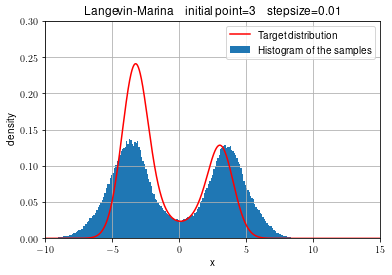

In [814]:
xx = ttr_1

plt.hist(xx,density=True,bins=200,label="Histogram of the samples")
#sns.kdeplot(xx, bw = .4, color = 'g')
plt.xlabel('x')
plt.ylabel('density')
plt.xlim((-10, 15))
plt.ylim((0, 0.3))

x_2 = np.linspace(-10,15,100000)
y_2 = [e**(-func(i))/5.711 for i in x_2]
plt.plot(x_2,y_2,'r',label="Target distribution")
plt.legend(loc="upper right")
plt.title("Langevin-Marina"'\quad initial point='+str(xinit)+'\quad stepsize='+str(stepsiz))
plt.grid()
plt.savefig("marina15.eps")
plt.show()


In [815]:
def QLSDpp(T,step_size,init,s):
    
    theta = np.zeros((T,d))
    theta[0,:] = init
    x = init
    eta = np.zeros((b,d))
    #eta_sum = np.sum(eta,axis=0)
    alpha = 0.2
    qgrad = np.zeros((b,d))
    theta_tmp = x

    l = 1000
    sample_size = 1
    
    for t in range(T):
        if t%l ==0:
            theta_tmp = x


        for i in range(b): 

            qgrad[i,:] = 0

            for j in range(sample_size):

                tmp_grad = 0

                idx = np.random.randint(0,2*n[i])

                if idx < 0:
                    tmp_grad = grad_func(x)-y[i][idx]*np.cos(x)-grad_func(theta_tmp)+y[i][idx]*np.cos(theta_tmp)
                if idx >= n[i] & idx>0:
                    tmp_grad = grad_func(x)-y[i][idx-n[i]]*np.cos(x)-grad_func(theta_tmp)+y[i][idx-n[i]]*np.cos(theta_tmp)

                qgrad[i,:] = qgrad[i,:] + tmp_grad

        
            # quantization with memory term eta
            qgrad[i,:] = SQuantization(s,qgrad[i,:]/sample_size+grad_func(theta_tmp)-eta[i,:])
            eta[i,:] = eta[i,:] +alpha* qgrad[i,:]
            #update eta
            #eta[i] = eta[i] + alpha*qgrad[i,:]



        # Update theta on server
        bb = np.sqrt(2*step_size) * np.random.normal(0,1,size=d)
        
        x = x - step_size * ((1/b)*(np.sum(qgrad,axis=0)+np.sum(eta,axis = 0))) + bb
        theta[t,:]=x
        #print(eta_sum[:2])
        #print(x[:1])
        #Update eta on server
        #eta_sum = np.sum(eta,axis=0)
            
    return theta

In [816]:
np.random.seed(seedd)
tmp = QLSDpp(400000,stepsiz,xinit,2**8)
ttr_2 = [ float(i) for i in tmp]



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


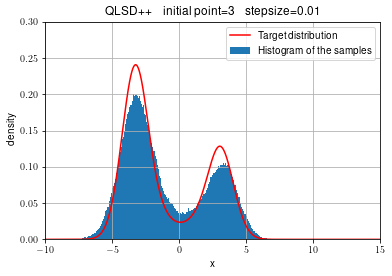

In [817]:
xxx = ttr_2

plt.hist(xxx,density=True,bins=200,label="Histogram of the samples")
#sns.kdeplot(xxx, bw = .4, color = 'g')
plt.xlabel('x')
plt.ylabel('density')
plt.title("QLSD++"'\quad initial point='+str(xinit)+'\quad stepsize='+str(stepsiz))
plt.xlim((-10, 15))
plt.ylim((0, 0.3))

x_3 = np.linspace(-10,15,100000)
y_3 = [e**(-func(i))/5.711 for i in x_3]
plt.plot(x_3,y_3,'r',label="Target distribution")
plt.legend(loc="upper right")
plt.grid()
plt.savefig("pp15.eps")
plt.show()


In [818]:
#calculate normalization constant Z
x = np.linspace(-30,30,10000000)
summ = 0
for i in range(10000000-1):
                    summ = summ +(x[i+1]-x[i])*e**(-func((x[i]+x[i+1])/2))
                  
print(summ)

5.711460688283492
